# Toy Model: Filtering

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
plt.rcParams['savefig.dpi'] = 400 
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.sbin import suppression_factor, suppression_factor_simple, suppression_simulation
from sbin import parameters

## Read in the data

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [2]:
# read in my kois table
with open('tables/kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# confirmed planets only
allbin = Table.read('tables/plan_allbinall.mrt', format='ascii.mrt').to_pandas()

mask = allbin['Alternate'].str.match(r'^KOI\d+(?:\.\d+)?$', na=False)
tmp = allbin.loc[mask].copy()
tmp['KOI'] = tmp['Alternate'].str.extract(r'KOI0*(\d+)', expand=False).astype(int)
db=tmp.merge(kois, on='KOI', suffixes=['','_y'])

## Review sample properties

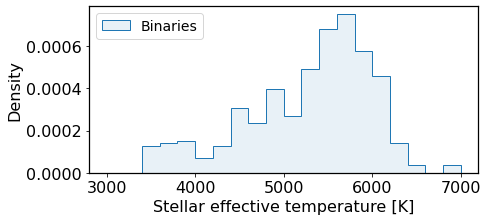

In [3]:
nbins = 20
histrange = (3000,7000)
fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

plt.hist(db['teff'], label='Binaries',
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')


plt.ylabel('Density')
plt.xlabel('Stellar effective temperature [K]')
plt.legend(loc='upper left')
plt.tight_layout()


In [4]:
q = db['Mass']/db['Mass_1']
RL = 0.49*q**(2/3)/(0.6*q**(2/3)+np.log(1+q**(1/3))) # verified against https://dev.adsabs.harvard.edu/scan/
disk = RL * db['semi-major']

db['DiskAU'] = disk

db['SnowAU'] = 0.00465*0.5*(db['teff']/170.)**2 # for T_eq = 170K

## Define subsamples

In [5]:
# period and stellar limits
plim = (db['koi_period'] < 100)
       

# filter the binaries
db_filtered = db[(db['koi_prad'] < parameters.radius_limit) & plim].copy()
close = db_filtered['semi-major']<100
good = (db_filtered['koi_prad_err1'] - db_filtered['koi_prad_err2'])/db_filtered['koi_prad'] < parameters.max_radius_error




In [6]:
bundle = {
    "db_filtered": db_filtered,      # pandas DataFrame
    "close": close,                  # boolean Series
    "good": good,                    # boolean Series
}

with open("filtered_data_thebault.pkl", "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)


## Get numbers for paper

In [ ]:
def calc_statistics(catalog, prad_col = 'Rp', star_col='KOI', MTPS=False):
    
    n_planets = float(len(catalog))
    print( "Number of planets: ", int(n_planets))
    print( "Number of stars: ", len(catalog[star_col].unique()))
    
    n_SEs = float(len(catalog.loc[catalog[prad_col]<parameters.radius_valley]))
    print("Frac super-Earths/n_planets: ", n_SEs/n_planets, "+-", np.sqrt(n_SEs)/n_planets)
    
    if MTPS:
        planet_counts = catalog.groupby(star_col).size().reset_index(name='n_planets')
        stps = len(planet_counts.loc[planet_counts['n_planets']==1])
        mtps = len(planet_counts.loc[planet_counts['n_planets']>1])
        print("Frac MTPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))


# ----------------------------------------------
# Print all the samples and sub-samples
# ----------------------------------------------

        
print("BINARIES\n\n All")
calc_statistics(db_filtered[good], prad_col='Rppri')

print("\n Close (error good)")
calc_statistics(db_filtered[good & close], prad_col='Rppri')

print("\n Wide (error good)")
calc_statistics(db_filtered[good & ~close], prad_col='Rppri')

print("\n Close (any error)")
calc_statistics(db_filtered[close], prad_col='Rppri', MTPS=True)

print("\n Wide (any error)")
calc_statistics(db_filtered[~close], prad_col='Rppri', MTPS=True)


print("\n\nSINGLE KOIS")
print("\n (err < lim)")
calc_statistics(kois_filtered[kois_good], prad_col='koi_prad')
print("\n (any err)")
calc_statistics(kois_filtered, prad_col='koi_prad', MTPS=True)
print("\nSINGLE CKS")
print("\n (err < lim)")
calc_statistics(cks_filtered[cks_good])
print("\n (any err)")
calc_statistics(cks_filtered, MTPS=True)

# Overview

In [ ]:
# ----------------------------------------------
# Set-up
# ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(7, 4))

# defining the limits of the semi-major axis
a_values = np.logspace(-0.1,3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 20)

# calculate suppression factors
S_values = suppression_factor(a_values)
S_values2 = suppression_factor_simple(a_values)


# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------


# define the samples
ses = db_filtered['SepAU'][(db['Rppri']<=1.5)] # super-Earths
ppp = db_filtered['SepAU'][(db['Rppri']>1.5) & (db['Rppri']<2) ] # in-betweens
mns = db_filtered['SepAU'][(db['Rppri']>=2) & (db['Rppri']<6) ] # mini-Neptunes

# plot the histograms
ax1.hist([ses, ppp, mns], bins=bins,
         alpha=1, color=['#ffd92f','#fc8d62','#8da0cb'], 
         stacked = True, label=[
                f'$\leq1.5 R_\\oplus$',
                f'$1.5 – 2 R_\\oplus$',
                f'$2 – 6 R_\\oplus$'])

ax1.set_xscale('log') # Set the x-axis to logarithmic scale
ax1.set_ylabel('Number of planets', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax1.set_xlabel('Projected stellar companion separation, a [au]')
plt.legend(edgecolor='None', facecolor='w')


# ----------------------------------------------
# Second axis -- the suppression equation
# ----------------------------------------------

ax2 = ax1.twinx()

ax2.plot(a_values, S_values, color='darkred', linestyle='-', label='Suppression Factor')
ax2.plot(a_values, S_values2, color='darkred', linestyle='--', label='Suppression Factor')
ax2.tick_params(axis='y', labelcolor='darkred')

ax2.set_ylabel('$S_\mathrm{bin}$', rotation=270, color='darkred', labelpad=15)


# ----------------------------------------------
# Adjust and save
# ----------------------------------------------

plt.xscale('log')
#plt.title('Suppression function from Moe & Kratter')
#plt.grid(True)
plt.tight_layout()
plt.savefig('overview.png')

In [ ]:
# ----------------------------------------------
# Set-up
# ----------------------------------------------


# defining the limits of the semi-major axis
a_values = np.logspace(0.3,3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 10)

# calculate suppression factors
S_values = suppression_factor(a_values)
S_values2 = suppression_factor_simple(a_values)


# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)

for xi in [0,1]:
    
    for tj in [0,1]:
        
        if xi==1:
            x = db['DiskAU']/db['SnowAU']
        else:
            x = db['semi-major']
            
        if tj == 0:
            # define the samples
            temp=r'$T_{eff}>6500 K$'
            mns = x[(db['Mass']>1.2)] # mini-Neptunes
        else:
            temp=r'$T_{eff}<4500 K$'
                # define the samples
            mns = x[(db['Mass']<0.7)] # mini-Neptunes


 
        axes[tj,xi].hist(mns, bins=bins,
             alpha=1, color='gray')
        axes[tj,xi].set_xscale('log') # Set the x-axis to logarithmic scale
        axes[tj,xi].tick_params(axis='y', labelcolor='k')

        if xi==1:
            #axes[tj,xi].text(0.95, 0.93, temp, 
            #     horizontalalignment='right', verticalalignment='top', transform=axes[tj,xi].transAxes)            
            if tj==1:
                axes[tj,xi].set_xlabel('Relative truncation radius')
            else:
                axes[tj,xi].legend(fontsize=12)
        else:
            axes[tj,xi].text(0.05, 0.93, temp, 
                 horizontalalignment='left', verticalalignment='top', transform=axes[tj,xi].transAxes)            
            axes[tj,xi].set_ylabel('Number of planets', color='k')
            if tj==1:
                axes[tj,xi].set_xlabel('Companion separation [au]')
    
    #plt.legend(edgecolor='None', facecolor='w')




    # ----------------------------------------------
    # Adjust and save
    # ----------------------------------------------

    plt.xscale('log')
    #plt.title('Suppression function from Moe & Kratter')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig('snowline-binall.png')